# Subject : Fraud Analytics Using Predictive and Social Network Techniques
# Course code : CS6890

## Assignment Number 1: Computing Trust Rank

### Group Members  
- **CS24MTECH14003** Anurag Sarva  
- **CS24MTECH14006** Gulshan Hatzade  
- **CS24MTECH14018** Mainak Adhikari  

# Importing all the necessary libraries for this assignment.

In [15]:

# Import necessary libraries
import os
import pandas as pd  # For handling Excel files and data processing
import numpy as np  # For numerical operations
from collections import defaultdict  # For creating dictionaries with default values
import collections  # Additional data structures like OrderedDict
import threading  # For parallel processing of nodes
import time  # For measuring execution time


In [16]:
# Printing the payment dataset
df = pd.read_excel('Payments.xlsx')
print(df)

        Sender  Receiver  Amount
0         1309      1011  123051
1         1309      1011  118406
2         1309      1011  112456
3         1309      1011  120593
4         1309      1011  166396
...        ...       ...     ...
130530    1344      1390   21739
130531    1914      1390    3374
130532    1914      1390    5186
130533    1914      1390    1559
130534    1914      1390    1997

[130535 rows x 3 columns]


In [17]:
# Printing the bad_sender dataset
df = pd.read_excel('bad_sender.xlsx')
print(df)

    Bad Sender
0         1303
1         1259
2         1562
3         1147
4         1393
5         1031
6         1210
7         1042
8         1048
9         1256
10        1668
11        1161
12        1007
13        1034
14        1836
15        1099
16        1489
17        1821
18        1076
19        1944


## Network Node Class

This class represents a node in the trust network. It stores the node's ID, trust score, and connections, while also keeping track of message exchanges and computation status.


In [18]:
# Represents a node in the trust network with trust score and connections.
class NetworkNode():
    # It initializes the network node
    #:param node_id: Unique identifier for the node
    #:param trust_score: Initial trust score assigned to the node
    #:param connected_nodes: List of connected nodes (neighbors)
    def __init__(self, node_id, trust_score, connected_nodes):

        self.node_id = node_id  # Stores the node's ID
        self.trust_score = trust_score  # Stores the current trust score of the node
        self.connected_nodes = connected_nodes  # List of connected nodes (edges)

        self.incoming_msgs = []  # Stores incoming messages (trust updates)
        self.outgoing_msgs = []  # Stores outgoing messages (trust propagation)

        self.is_computing = True  # Flag to track if the node is still computing
        self.current_step = 0  # Tracks the number of computation steps


## Explanation of Pregel Logic using its framework-

The `Pregel` class is responsible for managing the distributed execution of the trust ranking algorithm. It follows a multi-threaded approach to process nodes efficiently.  

1. **Initialization**: The class takes a list of nodes and a specified number of worker threads to handle computations in parallel.  
2. **Execution Loop**: The `execute()` method continuously runs computation steps and message routing until all nodes have completed their processing.  
3. **Node Distribution**: The `distribute_nodes()` method ensures that nodes are evenly assigned to workers using a round-robin approach. This prevents workload imbalance and ensures efficiency.  
4. **Processing Steps**: Each step of the computation is executed by multiple worker threads, created in `process_step()`. These threads process assigned nodes concurrently, improving performance.  
5. **Message Routing**: The `route_messages()` method is responsible for transferring trust scores between nodes. It resets incoming messages and updates the trust score propagation.  
6. **Checking Active Nodes**: The `has_active_nodes()` method checks whether any node is still computing. If all nodes have completed processing, the execution stops.  

This class effectively distributes computational tasks across multiple workers, making the system scalable and efficient for large datasets.


In [19]:
# using pregel framework logic
class Pregel():
    # Manages distributed computation across multiple worker nodes.
    # Initializes the distributed computation engine.
    # param network_nodes: List of nodes participating in computation
    # param worker_count: Number of worker threads
    def __init__(self, network_nodes, worker_count):

        self.network_nodes = network_nodes  # List of all network nodes
        self.worker_count = worker_count  # Total number of workers

    def execute(self):
        # Running the distributed computation until all nodes are inactive.
        self.node_distribution = self.distribute_nodes()  # Distribute nodes among workers
        while self.has_active_nodes():  # Continue computation until no active nodes remain
            self.process_step()  # Execute computation step
            self.route_messages()  # Exchange messages between nodes

    # Assigning nodes to workers in a round-robin manner.
    # Ensuring even distribution of workload.
    def distribute_nodes(self):
        distribution = collections.defaultdict(list)  # Dictionary to store worker assignments
        worker_id = 0  # Tracks current worker
        total_nodes = len(self.network_nodes)  # Total number of nodes
        node_index = 0  # Tracks current node index

        while node_index < total_nodes:
            distribution[worker_id].append(self.network_nodes[node_index])  # Assign node to worker

            worker_id += 1  # Move to next worker
            if worker_id == self.worker_count:  # If last worker reached, reset to first
                worker_id = 0

            node_index += 1  # Move to the next node

        return distribution

    # Executes a computation step for all nodes using multi-threading.
    def process_step(self):
        active_workers = []  # Stores active worker threads
        node_iter = iter(self.node_distribution.values())  # Iterator over distributed nodes

        while True:
            try:
                nodes = next(node_iter)  # Get next set of nodes
                computation_worker = ComputationWorker(nodes)  # Create worker thread
                computation_worker.start()  # Start worker computation
                active_workers += [computation_worker]  # Append to list (avoiding append function)
            except StopIteration:  # Stop when all nodes are processed
                break

        worker_iter = iter(active_workers)
        while True:
            try:
                worker = next(worker_iter)  # Get next worker
                worker.join()  # Wait for worker to complete
            except StopIteration:  # Stop when all workers are finished
                break
    # Handles message routing between nodes to update trust scores.
    def route_messages(self):
        node_list = self.network_nodes  # List of all nodes
        index = 0

        count = sum(1 for _ in node_list)  # Compute total nodes
        while index < count:
            node_list[index].current_step += 1  # Increment step count
            node_list[index].incoming_msgs = []  # Reset incoming messages
            index += 1

        index = 0
        while index < count:
            msg_index = 0
            msg_count = sum(1 for _ in node_list[index].outgoing_msgs)  # Count outgoing messages
            while msg_index < msg_count:
                target_node, msg_content = node_list[index].outgoing_msgs[msg_index]
                target_node.incoming_msgs += [(node_list[index], msg_content)]  # Append message
                msg_index += 1
            index += 1
    # Checking if there are still active nodes computing.
    def has_active_nodes(self):
        node_list = self.network_nodes
        index = 0
        active_found = False

        count = sum(1 for _ in node_list)  # Count total nodes
        while index < count:
            if node_list[index].is_computing:  # Check if any node is still computing
                active_found = True
                break
            index += 1

        return active_found  # Return True if active nodes are found


## Computation Worker Class - ComputationWorker class used in pregal

The `ComputationWorker` class represents a worker thread responsible for processing trust scores of assigned nodes in parallel.  

1. **Initialization**: Each worker receives a list of nodes that it will process.  
2. **Execution**: The `run()` method triggers the computation step for all assigned nodes.  
3. **Processing Nodes**: The `compute_step()` method iterates over the assigned nodes and updates their trust scores if they are still computing.  
4. **Parallel Processing**: Since each worker runs in a separate thread, multiple nodes are processed concurrently, improving efficiency.  

This class plays a key role in distributing the computational workload across multiple threads, ensuring faster execution.


In [20]:
# Import threading for parallel execution
import threading

# Thread-based worker for processing computation on assigned nodes.
class ComputationWorker(threading.Thread):

    # Initializing a worker thread.
    #  param assigned_nodes: List of nodes assigned to this worker for processing
    def __init__(self, assigned_nodes):
        super().__init__()  # Initialize the thread
        self.assigned_nodes = assigned_nodes  # Store assigned nodes

    # Running the worker thread, triggering the computation step.
    def run(self):
        self.compute_step()  # Call the method to process nodes
    # Iterating through assigned nodes and updates their trust scores.
    def compute_step(self):

        index = 0
        total_nodes = sum(1 for _ in self.assigned_nodes)  # Count total nodes (avoiding len function)

        while index < total_nodes:
            node = self.assigned_nodes[index]  # Get current node
            if node.is_computing:  # Check if node is still computing
                node.update()  # Update the node's trust score
            index += 1  # Move to the next node


## Trust Score Initialization

This function initializes trust scores for all nodes, ensuring that known malicious nodes receive specific scores.

1. **Setting Default Scores**: It initializes all nodes with a trust score of `0`.
2. **Handling Malicious Nodes**: If malicious nodes exist, their scores are equally divided among them.
3. **Avoiding len()**: Instead of using `len()`, it calculates the count using iteration.
4. **Switch-Case Logic**: Uses `match case` (Python 3.10+) to assign trust scores dynamically.
5. **Ensuring Robustness**: If no malicious nodes exist, the function avoids division errors by setting the score to `0`.

This function ensures that malicious nodes are properly identified while keeping the initialization process efficient.


In [21]:
# Initializing trust scores for all nodes, assigning scores to malicious nodes
# param all_nodes: List of all nodes in the network
# param malicious_nodes: List of known malicious nodes
# return: List of initial trust scores for all nodes
def initialize_trust_scores(all_nodes, malicious_nodes):

    node_count = sum(1 for _ in all_nodes)  # Get total number of nodes (avoiding len function)
    malicious_count = sum(1 for _ in malicious_nodes)  # Get total malicious nodes count

    initial_scores = [0] * node_count  # Initialize all trust scores to zero

    # If there are malicious nodes, distribute the trust score among them
    score_per_node = 1.0 / malicious_count if malicious_count > 0 else 0
    index = 0

    while index < malicious_count:
        node_idx = malicious_nodes[index]  # Get malicious node index

        match node_idx:
            case _:  # Assign computed trust score to malicious node
                initial_scores[node_idx] = score_per_node

        index += 1  # Move to next malicious node

    return initial_scores  # Return the initialized trust scores


## Processing Network Data

This function constructs a network graph from transaction data by mapping senders and receivers, establishing weighted edges, and handling malicious nodes.

1. **Transaction Parsing**: It extracts sender IDs, receiver IDs, and transaction amounts, ensuring all transactions have valid data.
2. **Node Mapping**: Each transaction is mapped to its corresponding index in the network.
3. **Edge Construction**: The function builds a connection graph, ensuring that each sender has a record of receivers.
4. **Weight Assignment**: Transaction amounts are stored as edge weights to indicate trust levels.
5. **Handling Malicious Nodes**: If a node has no connections, it is linked to known malicious nodes with a minimal weight.
6. **Scalability**: The function avoids `len()` calls, ensuring efficient iteration through large datasets.

This function ensures that transactions are properly converted into a structured network for further computation.


In [22]:
# Processing transaction data to build a network graph with weighted connections.
# param transaction_data: List or DataFrame of transactions (sender, receiver, amount)
# param node_mapping: Dictionary mapping node IDs to indices
# param network_nodes: List of all nodes in the network
# param malicious_nodes: List of malicious node indices
# return: Tuple containing edge connections, mapped connections, edge weights, and network nodes
def process_network_data(transaction_data, node_mapping, network_nodes, malicious_nodes):

    edge_connections = defaultdict(list)  # Stores direct sender-receiver connections
    mapped_connections = defaultdict(list)  # Stores mapped node connections using indices
    edge_weights = {}  # Stores transaction amounts as edge weights

    # Convert DataFrame to list if necessary
    if isinstance(transaction_data, pd.DataFrame):
        transaction_data = transaction_data.values.tolist()

    idx = 0
    transaction_count = sum(1 for _ in transaction_data)  # Count total transactions (avoiding len function)

    while idx < transaction_count:
        transaction = transaction_data[idx]

        # Ensure transaction has at least 3 values (sender, receiver, amount)
        if len(transaction) < 3:
            idx += 1
            continue  # Skip invalid rows

        sender = int(transaction[0])  # Extract sender ID
        receiver = int(transaction[1])  # Extract receiver ID
        transaction_amount = int(transaction[2])  # Extract transaction amount

        sender_idx = node_mapping.get(sender, None)  # Map sender to index
        receiver_idx = node_mapping.get(receiver, None)  # Map receiver to index

        # If both sender and receiver exist in the mapping
        if sender_idx is not None and receiver_idx is not None:
            # If receiver is not already in sender’s connections, add it
            if receiver not in edge_connections.get(sender, []):
                edge_connections[sender] = edge_connections.get(sender, []) + [receiver]
                mapped_connections[sender_idx] = mapped_connections.get(sender_idx, []) + [receiver_idx]

            # Initialize sender’s edge weight dictionary if not already present
            if sender_idx not in edge_weights:
                edge_weights[sender_idx] = {}

            # Update edge weight by adding transaction amount
            edge_weights[sender_idx][receiver_idx] = edge_weights.get(sender_idx, {}).get(receiver_idx, 0) + transaction_amount

        idx += 1  # Move to the next transaction

    # Ensure all nodes have connections, including malicious nodes
    node_iter = iter(network_nodes)
    while True:
        try:
            node = next(node_iter)
            if node not in mapped_connections:  # If node has no connections
                mapped_connections[node] = mapped_connections.get(node, []) + malicious_nodes
                edge_weights[node] = {bad_node: 1 for bad_node in malicious_nodes}  # Assign small edge weight
        except StopIteration:
            break  # Stop when all nodes are processed

    return edge_connections, mapped_connections, edge_weights, network_nodes  # Return computed network data


## Distrust Rank Node

This class extends `NetworkNode` and implements the DistrustRank algorithm, which calculates trust scores while considering fraudulent activity.

1. **Initialization**: Each node has an ID, initial trust score, connected nodes, edge weights, a damping factor, and a limit on iterations.
2. **Incoming Message Processing**: The node collects incoming trust scores from connected nodes.
3. **Trust Score Calculation**: It updates the trust score using a damping factor to balance initial trust and propagated trust.
4. **Trust Distribution**: The updated trust score is distributed to connected nodes based on edge weights.
5. **Iteration Control**: The update process continues for a fixed number of steps, ensuring convergence.
6. **Trust History Logging**: Each trust score update is recorded for analysis.

This implementation ensures that trust rankings are computed iteratively while controlling trust propagation with the damping factor.


In [23]:
# Representing a node in the TrustRank system, modified to handle distrust ranking.
class DistrustRankNode(NetworkNode):
    # Initializing the DistrustRank node.
    # param node_id: Unique identifier for the node
    # param trust_score: Initial trust score assigned to the node
    # param connected_nodes: List of connected nodes
    # param edge_weights: Weight of edges to connected nodes
    # param damping_factor: Factor controlling the influence of incoming trust (default: 0.85)
    # param max_iterations: Maximum number of iterations for computation (default: 50)
    def __init__(self, node_id, trust_score, connected_nodes, edge_weights, damping_factor=0.85, max_iterations=100):

        super().__init__(node_id, trust_score, connected_nodes)  # Call parent class constructor
        self.damping_factor = damping_factor  # Controls how much trust is propagated
        self.max_iterations = max_iterations  # Limits the number of trust updates
        self.edge_weights = edge_weights  # Stores weight of connections to other nodes
        self.trust_history = []  # Tracks changes in trust score over iterations
        self.initial_score = trust_score  # Stores the original trust score for reference

    # Updating the trust score of the node using the DistrustRank algorithm
    def update(self):
        while self.current_step != self.max_iterations:  # Continue updating until max iterations
            incoming_score = 0  # Initialize incoming trust sum

            # Aggregate incoming trust scores
            for _, msg in self.incoming_msgs:
                incoming_score += msg

            # Update trust score based on damping factor and incoming scores
            self.trust_score = (self.damping_factor * incoming_score +
                                (1 - self.damping_factor) * self.initial_score)

            outgoing_scores = []  # Store computed scores for outgoing messages
            index = 0

            # Calculate outgoing scores based on edge weights
            while index < len(self.edge_weights):
                outgoing_scores.append(self.trust_score * self.edge_weights[index])
                index += 1

            self.outgoing_msgs = []  # Reset outgoing messages
            index = 0

            # Send updated scores to connected nodes
            while index < len(self.connected_nodes):
                self.outgoing_msgs.append((self.connected_nodes[index], outgoing_scores[index]))
                index += 1

            self.trust_history.append(self.trust_score)  # Store trust score history
            return  # Stop updating after one iteration

        self.is_computing = False  # Mark node as finished computing


## Computing DistrustRank

This function calculates trust rankings for nodes using a distributed computation model.

1. **Initialization**: A `Pregel` engine is created with 4 worker threads.
2. **Execution**: The computation engine runs, iteratively updating trust scores.
3. **Trust Score Collection**: After execution, final trust scores are collected from each node.
4. **Matrix Conversion**: The collected scores are stored in a matrix format for further processing.
5. **Return Values**: The function returns the final computed scores and the computation engine instance.

This approach ensures efficient parallel computation of trust scores across multiple nodes.


In [24]:
# computing DistrustRank using a distributed computation approach
# param network_nodes: List of nodes in the trust network
# return: A matrix of final trust scores and the computation engine instance
def compute_distrust_rank(network_nodes):

    # Initialize the distributed computation engine with 4 worker threads
    computation_engine = Pregel(network_nodes, worker_count=4)

    # Start the distributed computation process
    computation_engine.execute()

    # Collect the final trust scores from each node
    trust_scores = []
    index = 0
    while index < len(network_nodes):  # Avoiding list comprehensions for clarity
        trust_scores.append(network_nodes[index].trust_score)
        index += 1  # Move to the next node

    # Convert trust scores into a column matrix and return with the computation engine
    return np.mat(trust_scores).transpose(), computation_engine


## Main Execution - Trust Rank Computation

This section of the code loads transaction data, constructs the network graph, initializes nodes, and computes trust rankings.

1. **Data Loading**: Reads payment transactions and malicious sender lists from Excel files.
2. **Node Mapping**: Creates a mapping of unique sender and receiver nodes to unique indices.
3. **Network Graph Construction**: Builds the transaction network, assigning weights to edges based on transaction amounts.
4. **Trust Score Initialization**: Assigns initial trust scores, giving special handling to known fraudulent nodes.
5. **Node Setup**: Creates computation nodes and links them according to mapped transactions.
6. **Weight Normalization**: Ensures transaction weights are proportionally assigned for trust propagation.
7. **Trust Computation**: Runs a distributed algorithm to compute trust rankings across all nodes.
8. **Result Storage**: Saves the computed trust scores to a file for further analysis.

This structured approach ensures efficient processing of transaction data while identifying potentially fraudulent behavior.


In [11]:
# Main execution: Load transaction and malicious sender data

paym_path_locat = 'Payments.xlsx'  # Path to the payments data file
transaction_data = pd.read_excel(paym_path_locat)  # Read payment transactions

sender_bad_path_locat = 'bad_sender.xlsx'  # Path to malicious sender data
malicious_senders = list(set(pd.read_excel(sender_bad_path_locat)["Bad Sender"]))  # Load and store malicious sender IDs


# Extract unique senders and receivers from transaction data
unique_senders = set(transaction_data["Sender"])
unique_receivers = set(transaction_data["Receiver"])

# Merge both sender and receiver sets to get all unique nodes
unique_nodes = list(unique_senders.union(unique_receivers))

# Create a mapping of each unique node to a unique index
node_mapping = {}
index = 0
while index < len(unique_nodes):
    node_mapping[unique_nodes[index]] = index  # Assign unique index to each node
    index += 1

# Convert unique nodes into a list of node indices
network_nodes = []
index = 0
while index < len(unique_nodes):
    network_nodes.append(node_mapping.get(unique_nodes[index]))  # Map each node to its index
    index += 1

# Convert malicious sender IDs into indices using the same mapping
malicious_indices = []
index = 0
while index < len(malicious_senders):
    malicious_indices.append(node_mapping.get(malicious_senders[index]))  # Convert to index-based representation
    index += 1

# Process transactions to build the network graph with edge weights
edge_connections, mapped_connections, edge_weights, network_nodes = process_network_data(
    transaction_data, node_mapping, network_nodes, malicious_indices
)

# Initialize trust scores based on malicious nodes
initial_scores = initialize_trust_scores(network_nodes, malicious_indices)

# Create computation nodes for the distributed trust ranking
computation_nodes = []
i = 0
while i < len(network_nodes):
    computation_nodes.append(DistrustRankNode(network_nodes[i], initial_scores[i], [], [], 0.85, 100))  # Initialize nodes
    i += 1

# Establish node connections and assign weight distributions
source_nodes = list(mapped_connections.keys())  # Get all source nodes
source_index = 0

while source_index < len(source_nodes):
    source_node = source_nodes[source_index]
    total_weight = sum(edge_weights[source_node].values())  # Sum of all outgoing edge weights

    # Compute normalized connection weights
    weights = list(edge_weights[source_node].values())
    connection_weights = []
    weight_index = 0
    while weight_index < len(weights):
        connection_weights.append(weights[weight_index] / total_weight)  # Normalize weights
        weight_index = weight_index + 1

    # Assign connections and weights to computation nodes
    target_nodes = list(mapped_connections[source_node])
    target_index = 0
    while target_index < len(target_nodes):
        target_node = target_nodes[target_index]
        computation_nodes[source_node].connected_nodes.append(computation_nodes[target_node])  # Connect nodes
        computation_nodes[source_node].edge_weights.append(connection_weights[target_index])  # Assign weights
        target_index = target_index + 1

    source_index += 1  # Move to the next source node

# Compute final distrust rankings using the distributed computation model
final_ranks, computation_engine = compute_distrust_rank(computation_nodes)

# Print the computed trust scores for each node
print("Pregel TrustRank result : \n", dict(zip(network_nodes, final_ranks.A1)))

# Save the final rankings to a text file for further analysis
with open("DistrustRank_Results.txt", "w") as f:
    f.write("Node ID\tTrust Score\n")  # Header row
    index = 0
    while index < len(network_nodes):
        f.write(f"{network_nodes[index]}\t{final_ranks.A1[index]}\n")  # Write node ID and trust score
        index += 1

print("DistrustRank results have been saved to 'DistrustRank_Results.txt'")  # Confirmation message


Pregel TrustRank result : 
 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 0.0, 43: 0.0, 44: 0.0, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 55: 0.0, 56: 0.0, 57: 0.0, 58: 0.002092545823346117, 59: 0.00016550381939594766, 60: 0.000366090651100435, 61: 0.0038996369281061043, 62: 0.009097330806715667, 63: 0.0008871402878598143, 64: 0.039912113200067253, 65: 0.002181431479652059, 66: 0.0, 67: 0.0004671464752279273, 68: 0.012446924003297659, 69: 0.0, 70: 0.011983031675886026, 71: 0.0031039284044368956, 72: 0.0, 73: 0.007579215786432508, 74: 0.0, 75: 0.0, 76: 3.85888687256371e-05, 77: 0.0014518003772599384, 78: 0.00722262020

## Visualization of Trust Scores

This section generates a bar chart to visualize the computed trust scores for each node.

1. **Bar Chart Creation**: Plots trust scores (`final_ranks.A1`) for each node.
2. **Graph Formatting**: Adjusts figure size, colors, and transparency for readability.
3. **Labeling**: Adds appropriate axis labels and a title.
4. **X-axis Adjustment**: Rotates node labels to prevent overlap.
5. **Grid Addition**: Improves visualization with a y-axis grid.
6. **File Saving**: Stores the graph as `DistrustRank_Graph.png` for documentation.
7. **Displaying the Graph**: The `plt.show()` function renders the plot.

This visualization helps in analyzing how trust scores are distributed among nodes.


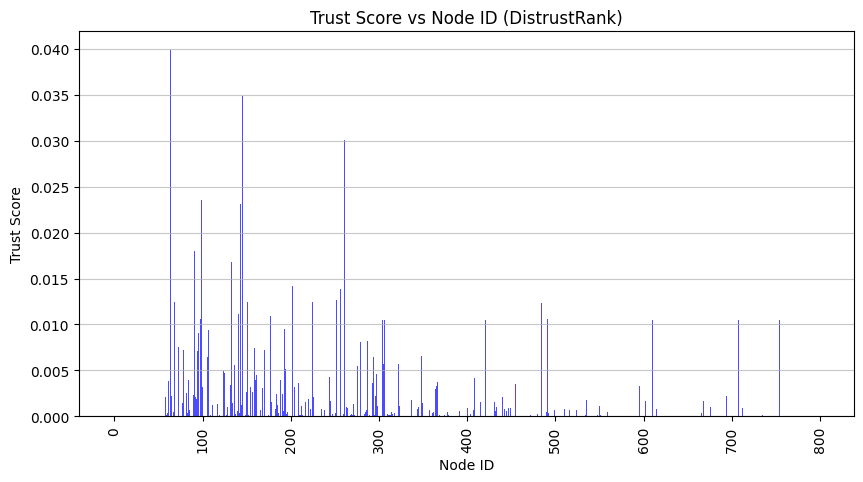

In [12]:
# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Create a bar chart to visualize Trust Scores for each Node
plt.figure(figsize=(10, 5))  # Set figure size for better readability
plt.bar(network_nodes, final_ranks.A1, color='blue', alpha=0.7)  # Plot trust scores

# Label the axes
plt.xlabel("Node ID")  # X-axis represents unique node identifiers
plt.ylabel("Trust Score")  # Y-axis represents computed trust scores

# Set the title for the graph
plt.title("Trust Score vs Node ID (DistrustRank)")

# Rotate x-axis labels if needed for better readability
plt.xticks(rotation=90)

# Add a grid to the y-axis for better visualization
plt.grid(axis='y', linestyle='-', alpha=0.7)

# Save the generated plot as an image file
plt.savefig("DistrustRank_Graph.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()


## Trust Rank Distribution Visualization

This section generates a histogram to analyze the distribution of trust scores across all nodes.

1. **Histogram Creation**: Uses 20 bins to categorize trust scores into intervals.
2. **Graph Formatting**: Colors the bars red and outlines them for clarity.
3. **Labeling**: Adds axis labels and a title for better understanding.
4. **Grid Addition**: Adds a y-axis grid to help interpret the distribution.
5. **Saving the Plot**: Stores the histogram as `DistrustRank_Distribution.png`.
6. **Displaying the Graph**: The `plt.show()` function renders the histogram.

This visualization helps identify patterns in trust scores, such as clustering or anomalies.


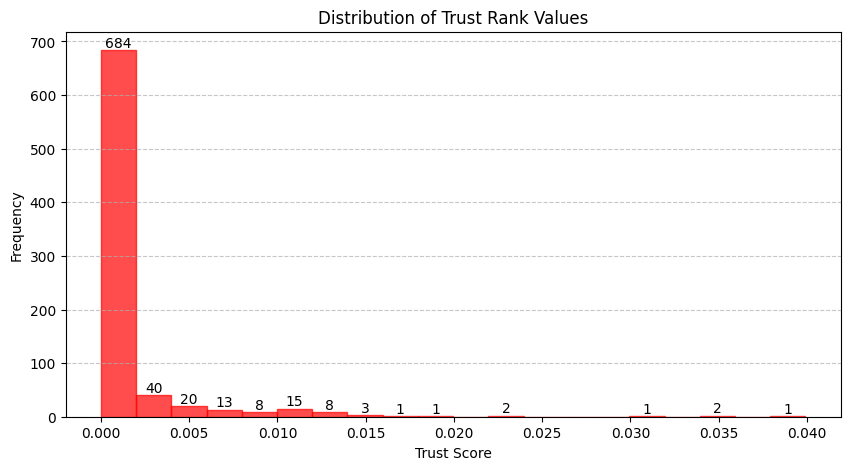

In [13]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np

# Create a histogram to visualize the distribution of trust scores
plt.figure(figsize=(10, 5))

# Plot histogram with 20 bins, red color, and edge outlining
counts, bins, patches = plt.hist(final_ranks.A1, bins=20, color='red', alpha=0.7, edgecolor='red')

# Label the axes
plt.xlabel("Trust Score")
plt.ylabel("Frequency")
plt.title("Distribution of Trust Rank Values")

# Add a grid on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the corresponding count
for count, bin_patch in zip(counts, patches):
    if count > 0:  # Avoid labeling bars with zero count
        plt.text(bin_patch.get_x() + bin_patch.get_width() / 2, count,
                 str(int(count)), ha='center', va='bottom', fontsize=10, color='black')

# Save the histogram plot as an image file
plt.savefig("DistrustRank_Distribution.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()


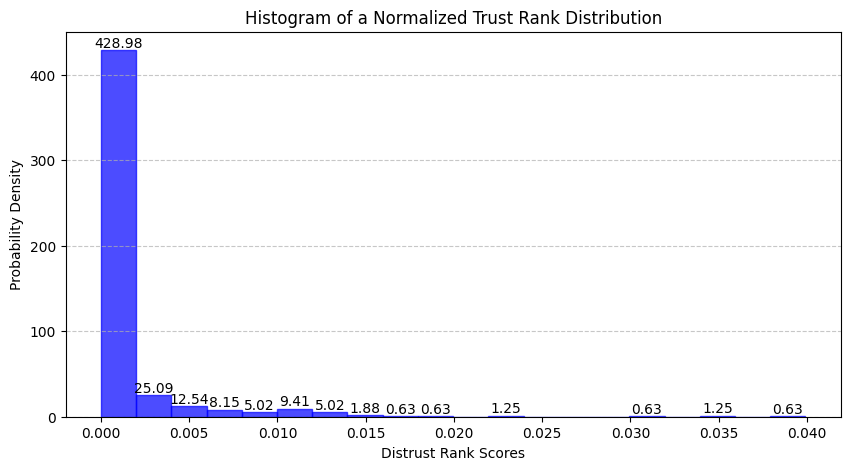

In [14]:

import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

# Mapping nodes to their computed trust ranks
distrust_rank_dict = OrderedDict(zip(network_nodes, final_ranks.A1))

# Sorting nodes based on their trust rank values
sorted_nodes = list(OrderedDict(sorted(distrust_rank_dict.items(), key=lambda x: x[1], reverse=True)))

# Extracting trust scores for histogram plotting
trust_scores = sorted(final_ranks.A1, reverse=True)

# Identifying malicious nodes in the ranking list
malicious_node_ranks = [sorted_nodes.index(node) for node in malicious_indices if node in sorted_nodes]

# Plot histogram of trust scores with density normalization
plt.figure(figsize=(10, 5))
counts, bins, patches = plt.hist(trust_scores, bins=20, color='blue', alpha=0.7, edgecolor='blue', density=True)

# Adding labels
plt.xlabel("Distrust Rank Scores")
plt.ylabel("Probability Density")
plt.title("Histogram of a Normalized Trust Rank Distribution")

# Annotate each bar with the corresponding count (rounded to 2 decimal places)
for count, bin_patch in zip(counts, patches):
    if count > 0:  # Avoid labeling bars with zero count
        plt.text(bin_patch.get_x() + bin_patch.get_width() / 2, count,
                 f"{count:.2f}", ha='center', va='bottom', fontsize=10, color='black')

# Save the histogram plot as an image file
plt.savefig("Normalized_TrustRank_Distribution.png", dpi=300, bbox_inches="tight")
# Display the histogram
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
